## Notebook 10 - Mirror plots

This notebook generates mirror plots for our validation results.

In [ ]:
%run ../common.py

In [10]:
import pandas as pd
import os
from pyopenms import MSExperiment, MzMLFile
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from common import cosine_greedy_score

In [11]:
df = pd.read_csv('mirror_plots_info.csv')

In [12]:
ppm = 10
test = lambda mz, ref_mz: ((abs(mz - ref_mz)/mz) * 1e6) < ppm # boolean 2D matrix

df_res = pd.DataFrame()
for _, row in tqdm(df.iterrows()):    
    name = row['Substrate file names']
    ref_mz_substrate = row['S m/z']
    ref_mz_monoproduct = row['P m/z']
    ref_mz_diproduct = row['D m/z']
    formatted_name = row['Substrates']
    rt_substrate_min = row['RTmin_substrate'] * 60.
    rt_substrate_max = row['RTmax_substrate'] * 60.
    rt_mono_min = row['RTmin_mono'] * 60.
    rt_mono_max = row['RTmax_mono'] * 60.

    # Search for any file containing the name
    file_pattern = f'./mzML/*{name}*.mzML'
    matching_files = glob.glob(file_pattern)
    
    if not matching_files:
        print(f'No files found matching {name}')
        continue

    for filename in matching_files:

        max_substrate_i, max_monoproduct_i, max_diproduct_i = 0., 0., 0.
        i_substrate, i_monoproduct, i_diproduct = [],[],[]
        mz_substrate, mz_monoproduct, mz_diproduct = [],[],[]
        mz_substrate_precursor, mz_monoproduct_precursor, mz_diproduct_precursor = np.nan, np.nan, np.nan

        exp = MSExperiment()
        MzMLFile().load(filename, exp)

        # Let us identify the most intense spectra for substrate, monoproduct and diproduct
        for spec in exp:
            if spec.getMSLevel() == 2:
                mz_precursor = spec.getPrecursors()[0].getMZ()
                mz_peaks, i_peaks = spec.get_peaks()
                rt = spec.getRT()

                if test(mz_precursor, ref_mz_substrate) & (max(i_peaks) > max_substrate_i):
                    if not pd.isna(rt_substrate_min):
                        if rt < rt_substrate_min:
                            continue
                    if not pd.isna(rt_substrate_max):
                        if rt > rt_substrate_max:
                            continue
                    mz_substrate = mz_peaks
                    i_substrate = i_peaks
                    max_substrate_i = max(i_peaks)
                    mz_substrate_precursor = mz_precursor
                
                elif test(mz_precursor, ref_mz_monoproduct) & (max(i_peaks) > max_monoproduct_i):
                    if not pd.isna(rt_mono_min):
                        if rt < rt_mono_min:
                            continue
                    if not pd.isna(rt_mono_max):
                        if rt > rt_mono_max:
                            continue
                    mz_monoproduct = mz_peaks
                    i_monoproduct = i_peaks
                    max_monoproduct_i = max(i_peaks)
                    mz_monoproduct_precursor = mz_precursor
                
                elif test(mz_precursor, ref_mz_diproduct) & (max(i_peaks) > max_diproduct_i):
                    mz_diproduct = mz_peaks
                    i_diproduct = i_peaks
                    max_diproduct_i = max(i_peaks)
                    mz_diproduct_precursor = mz_precursor
        
        # Let us now save the mz
        base_filename = os.path.basename(filename)
        name_without_extension = os.path.splitext(base_filename)[0]

        df_tmp = pd.DataFrame({
            'name': formatted_name,
            'filename': name_without_extension,
            'mz_substrate': [mz_substrate],
            'i_substrate': [i_substrate],
            'mz_substrate_precursor': mz_substrate_precursor,
            'mz_monoproduct': [mz_monoproduct],
            'i_monoproduct': [i_monoproduct],
            'mz_monoproduct_precursor': mz_monoproduct_precursor,
            'mz_diproduct': [mz_diproduct],
            'i_diproduct': [i_diproduct],
            'mz_diproduct_precursor': mz_diproduct_precursor,
        })

        df_res = pd.concat([df_res, df_tmp], ignore_index=True)

31it [01:54,  3.68s/it]


In [13]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.figsize'] = (6, 4.5)  # Set default figure size


def plot_mirror(mz_prod, i_prod, mz_ref, i_ref, mz_prod_precursor, mz_ref_precursor, title=None, filename=None):
    plt.figure(figsize=(6, 4))  # Ensure consistent figure size

    i_prod = np.array(i_prod) / max(i_prod)
    i_ref = np.array(i_ref) / max(i_ref)

    for mz, i in zip(mz_prod, i_prod):
        plt.plot([mz, mz], [0, i], c='#404288', linewidth=1)

    for mz, i in zip(mz_ref, i_ref):
        plt.plot([mz, mz], [0, -i], c='black', linewidth=1)
    
    if title:
        plt.title(title)

    cosine_score = np.round(cosine_greedy_score(mz_prod, i_prod, mz_ref, i_ref), 4)
    x_min = plt.gca().get_xlim()[0]
    x_max = plt.gca().get_xlim()[1]
    x_pos = x_min + 0.03 * (x_max - x_min)
    plt.annotate(f'Precursor $m/z$ = {mz_prod_precursor:.4f}', (x_pos, 1.1), va='center', fontsize=14)
    plt.annotate(f'Precursor $m/z$ = {mz_ref_precursor:.4f}. Cosine score = {cosine_score:.3f}', 
                 (x_pos, -1.1), va='center', fontsize=14)
    
    plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
    
    plt.ylim([-1.2, 1.2])
    plt.xlabel('m/z')
    plt.ylabel('Relative intensity')
    plt.yticks([-1, -0.5, 0, 0.5, 1])
    plt.tick_params(axis='y', direction='in')

    # Remove the top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)

    # Keep the left spine visible
    plt.gca().spines['left'].set_visible(True)
    
    if filename:
        plt.savefig(f'../results_val/figures/mirrorplots/{filename}.svg', 
                    format='svg', 
                    bbox_inches='tight', 
                    pad_inches=0, 
                    facecolor='white', 
                    edgecolor='white')
    plt.show()


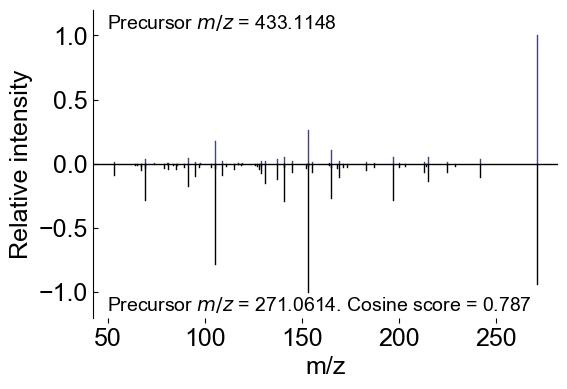

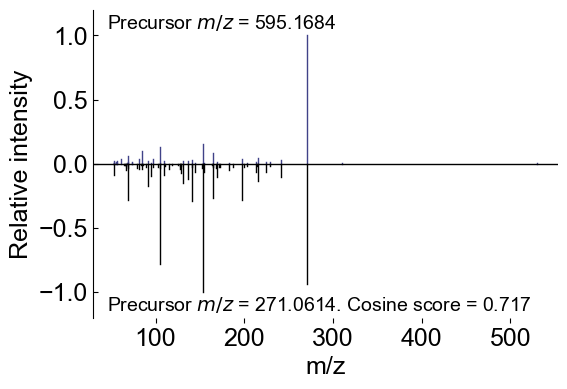

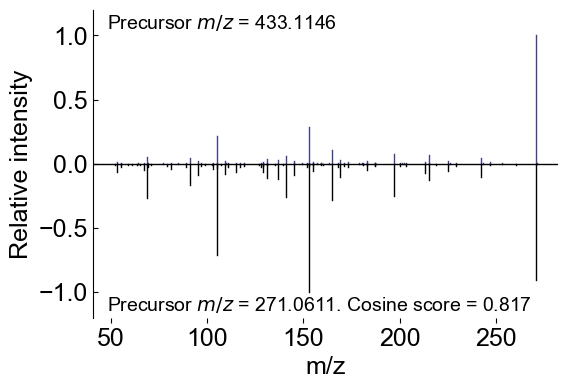

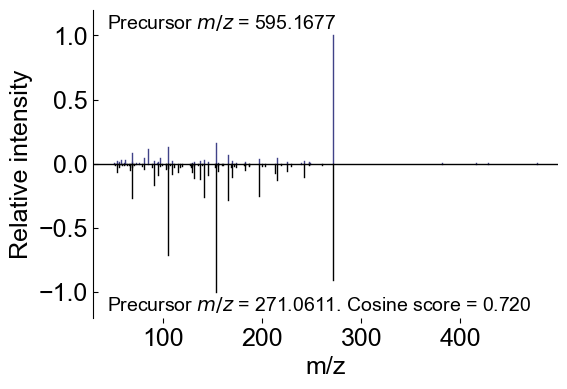

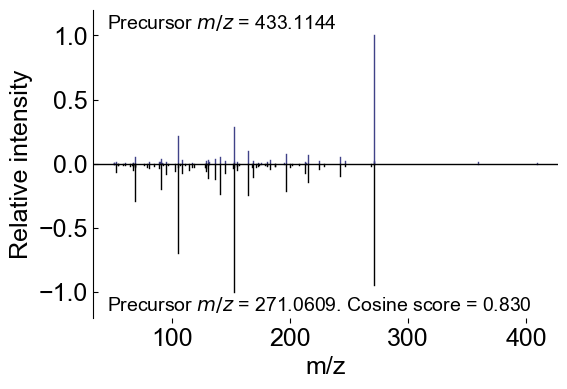

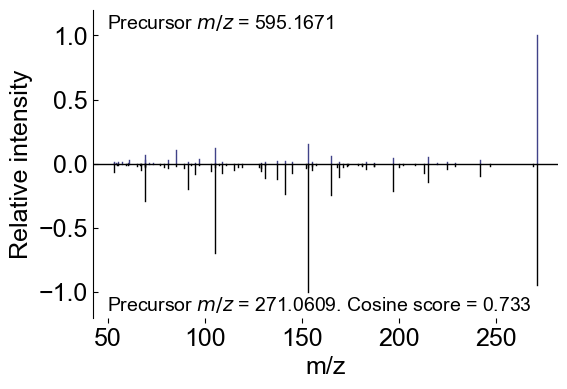

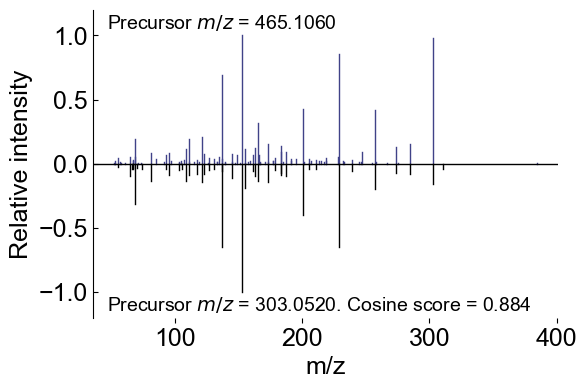

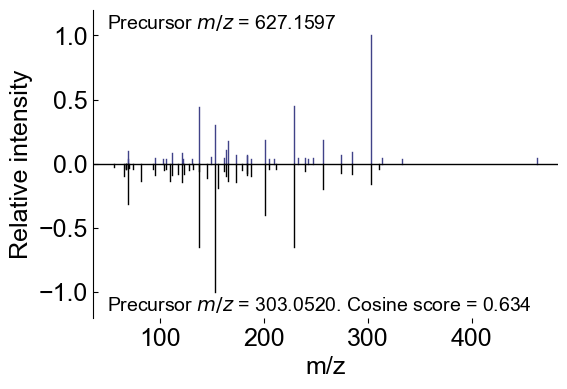

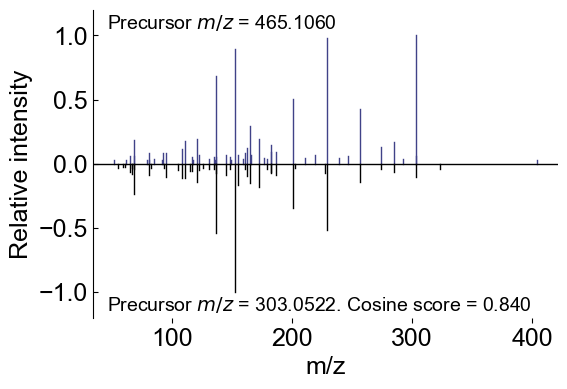

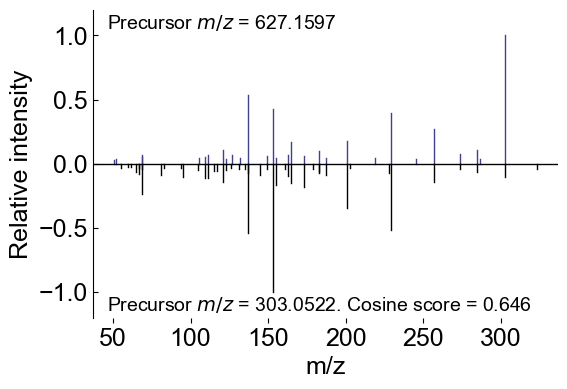

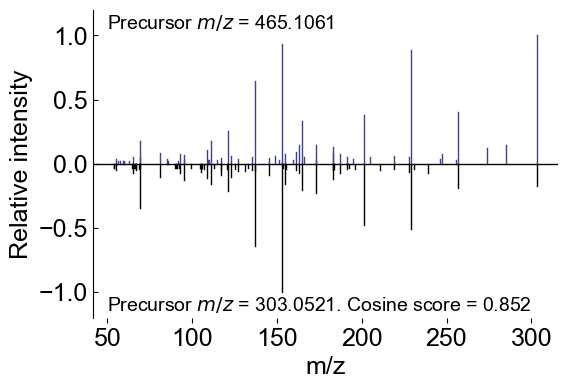

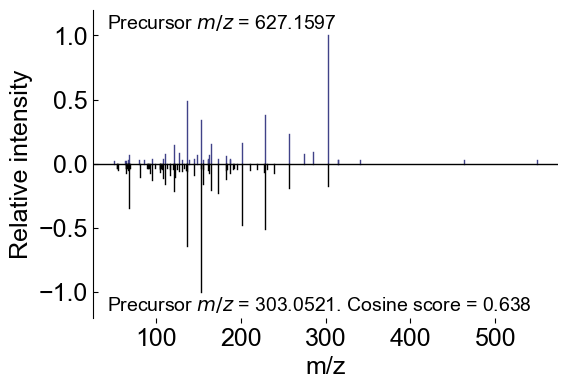

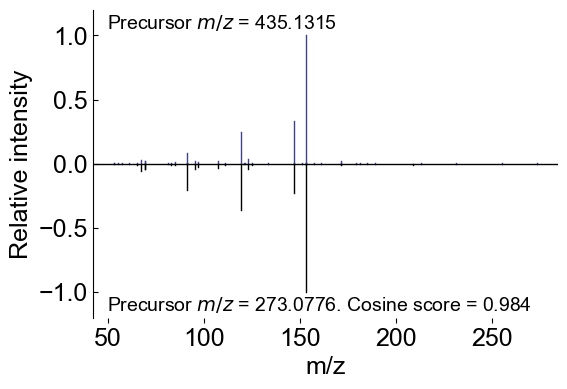

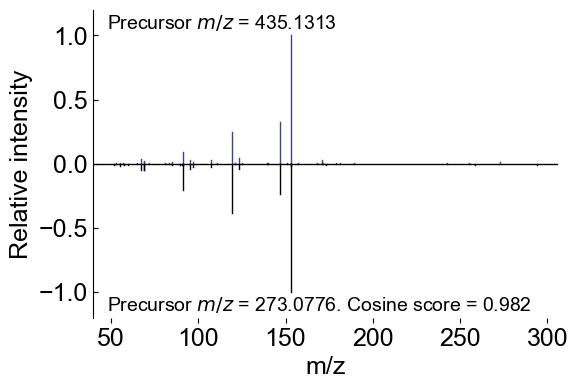

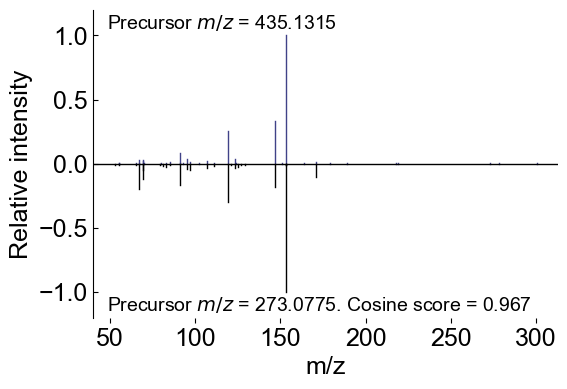

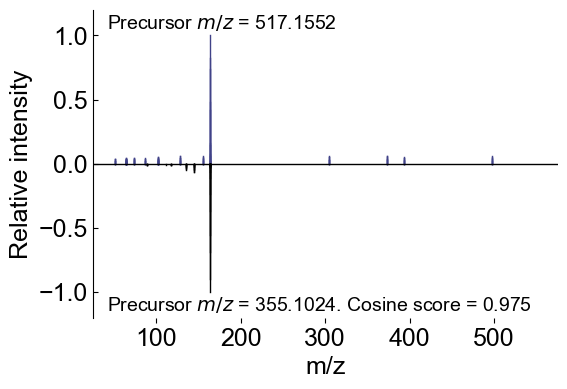

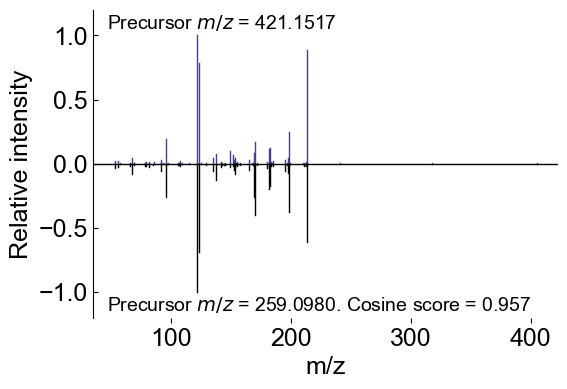

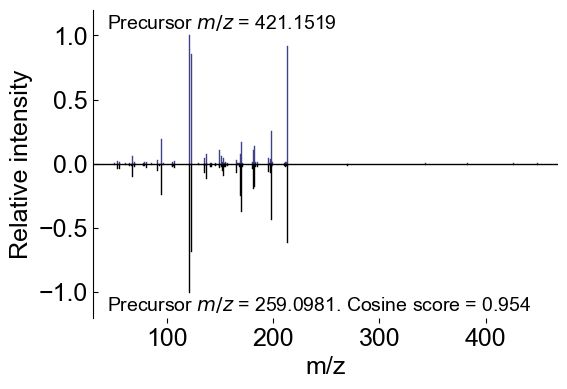

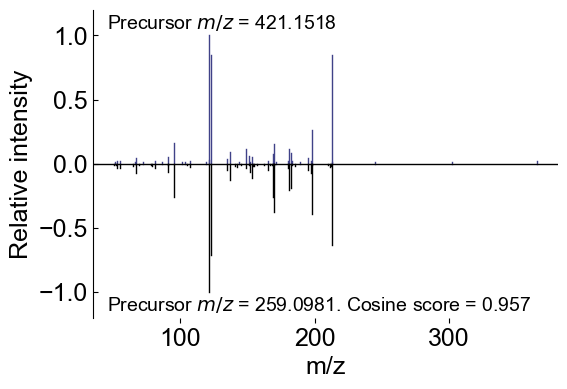

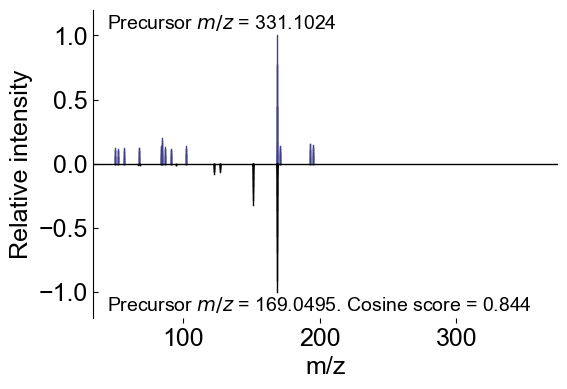

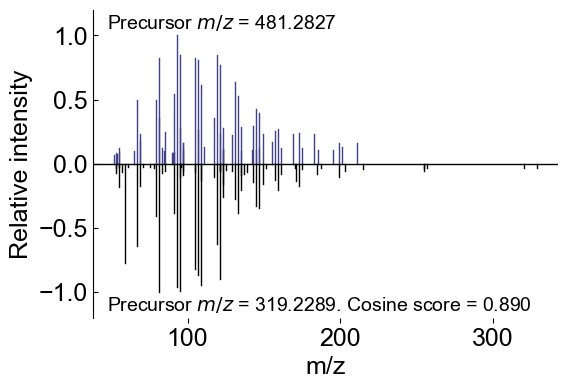

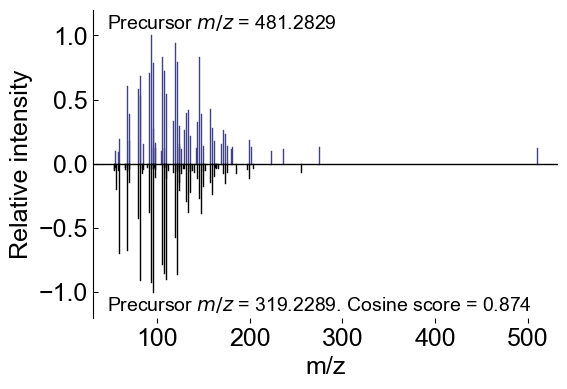

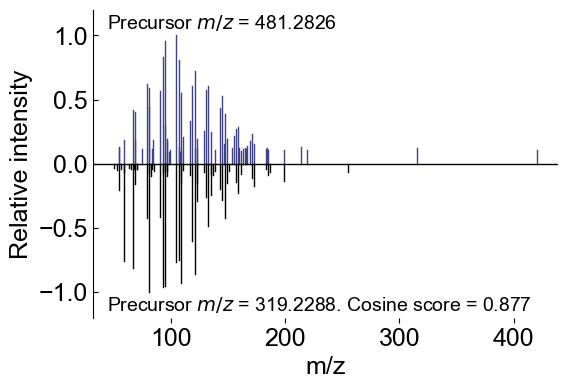

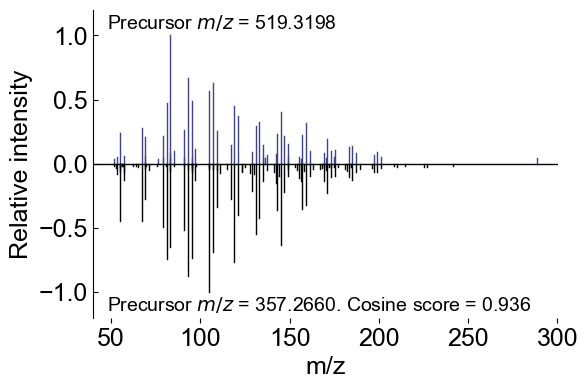

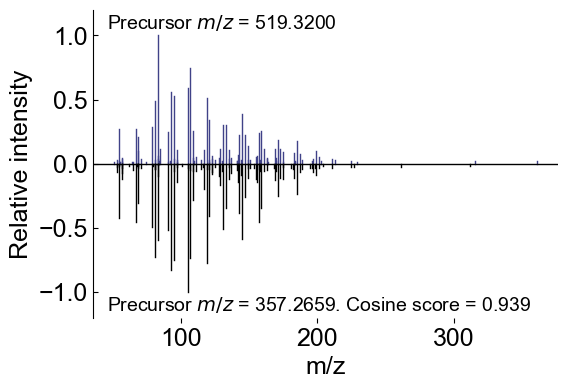

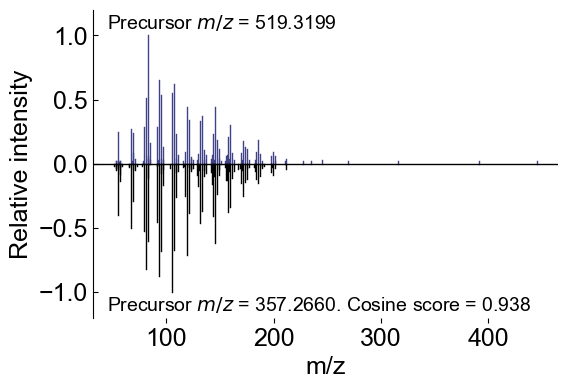

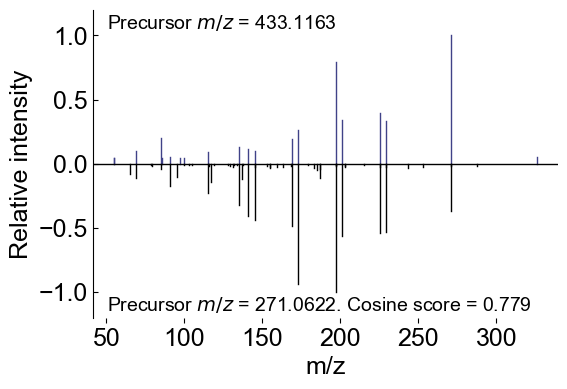

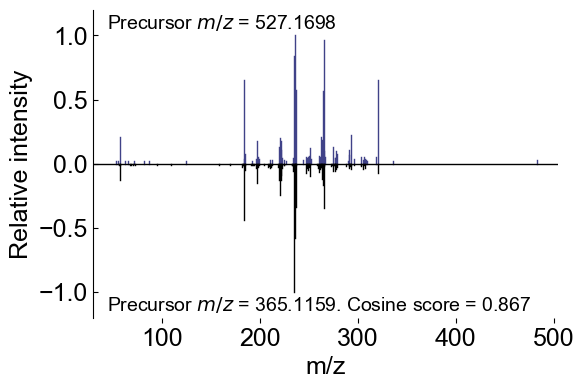

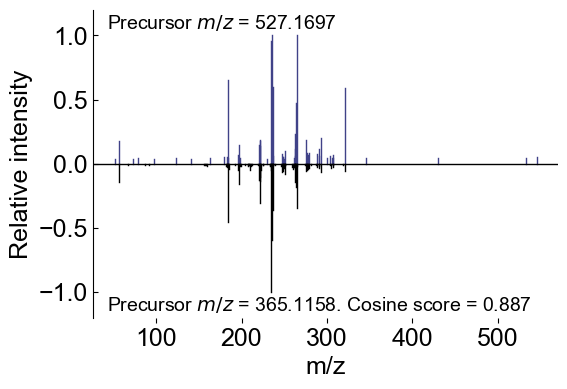

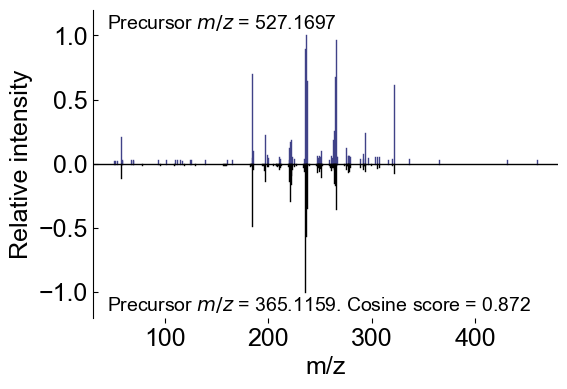

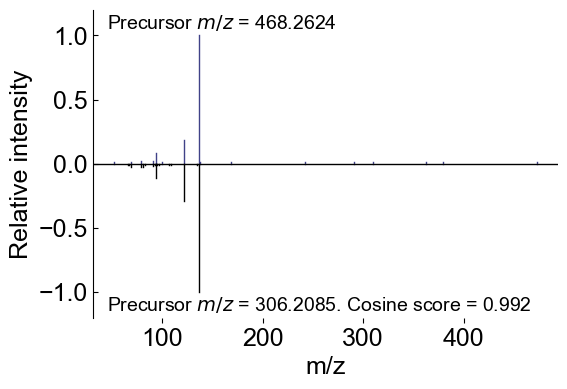

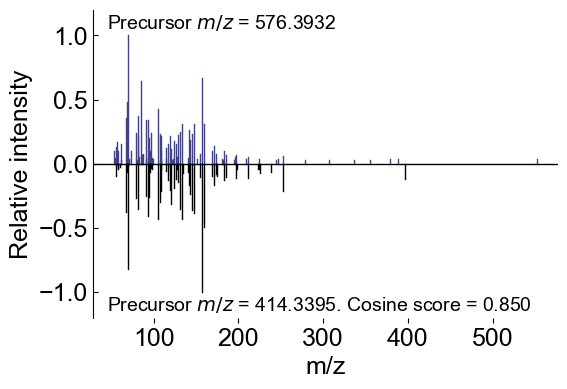

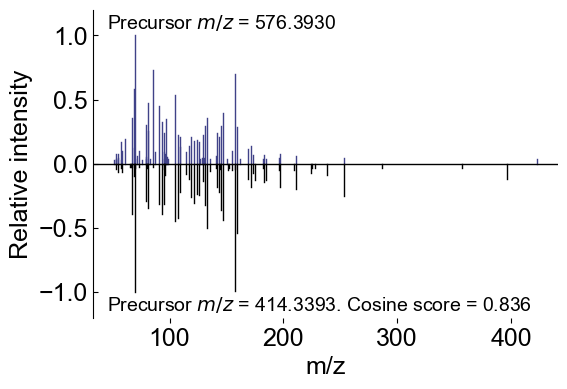

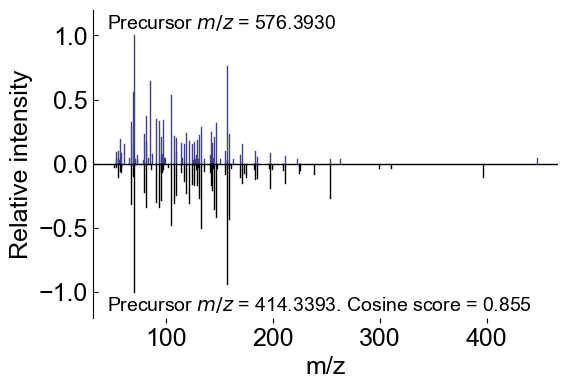

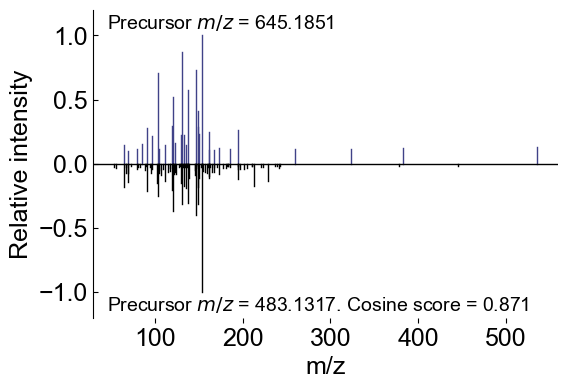

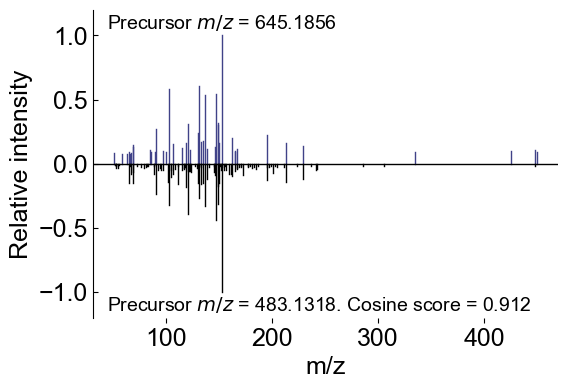

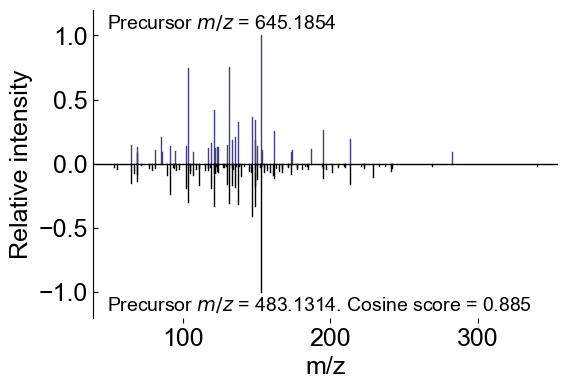

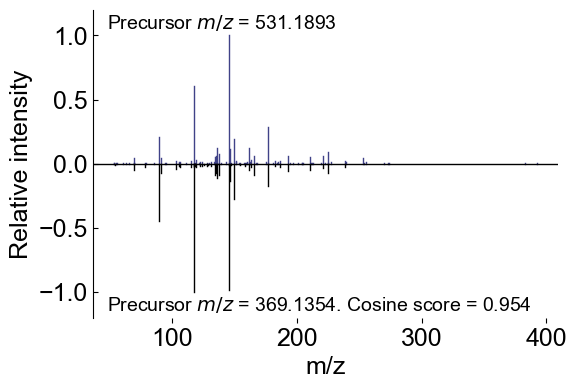

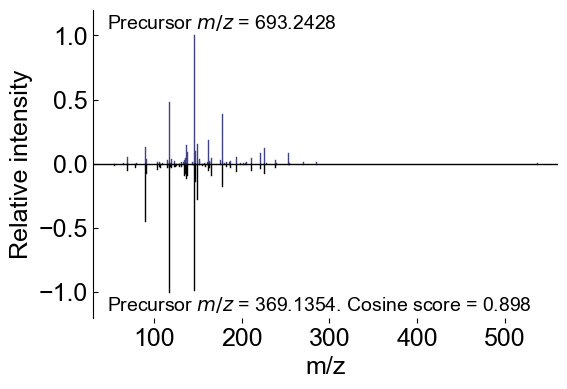

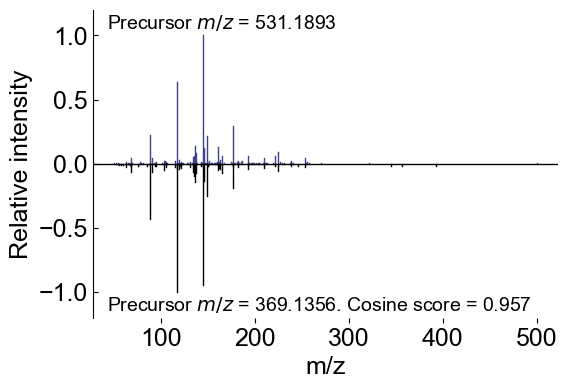

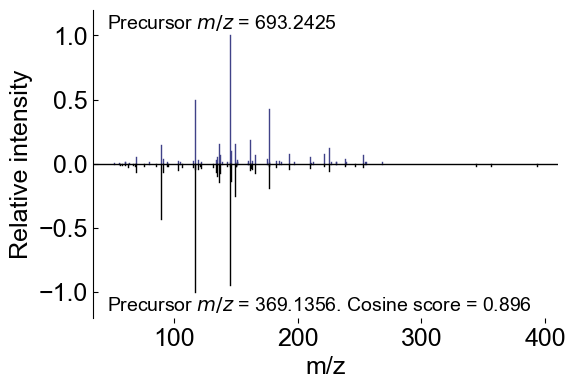

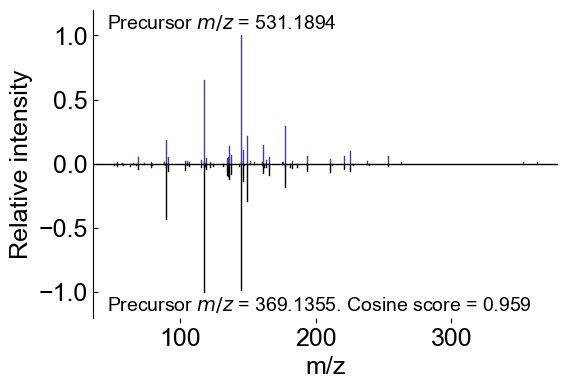

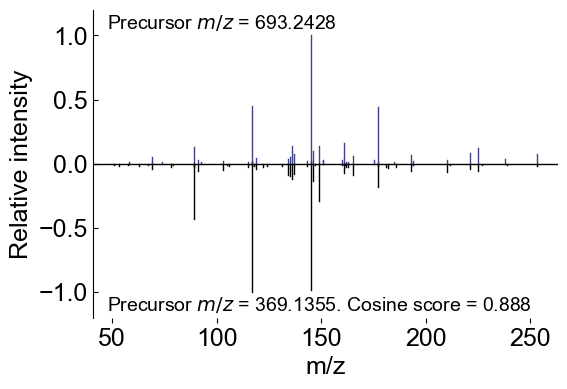

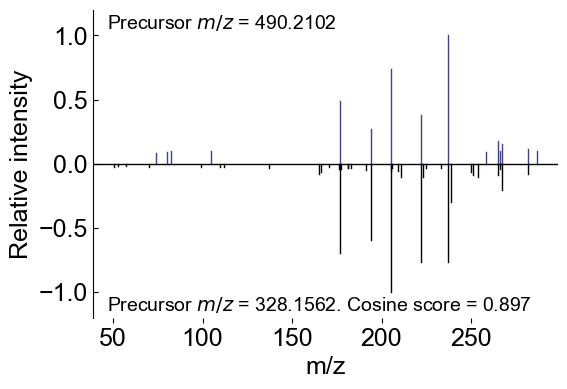

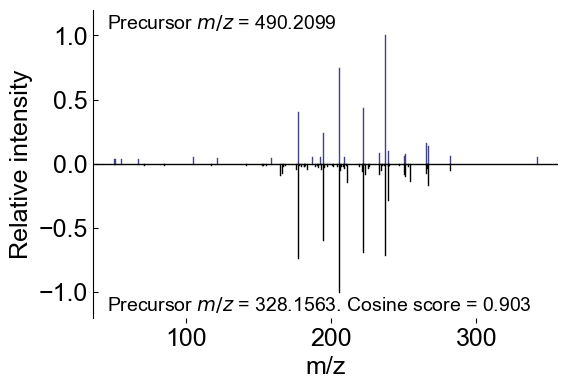

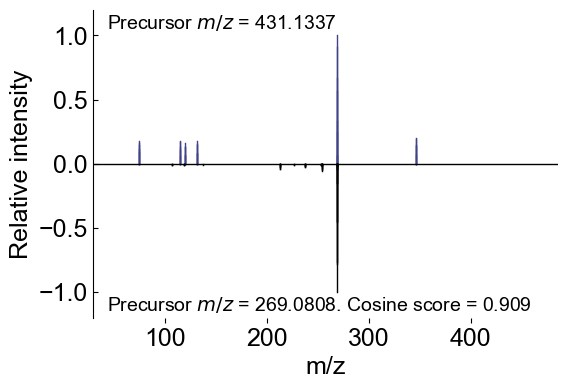

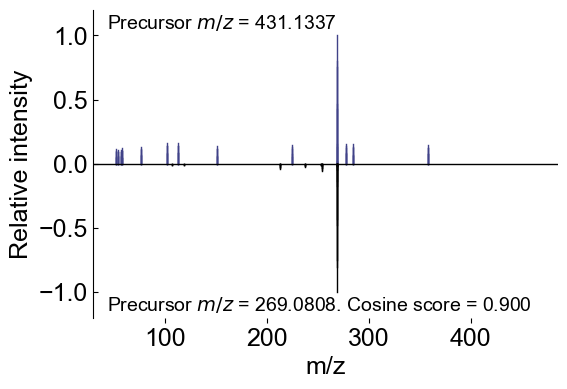

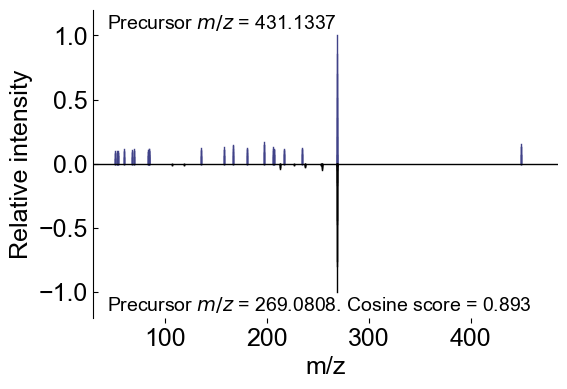

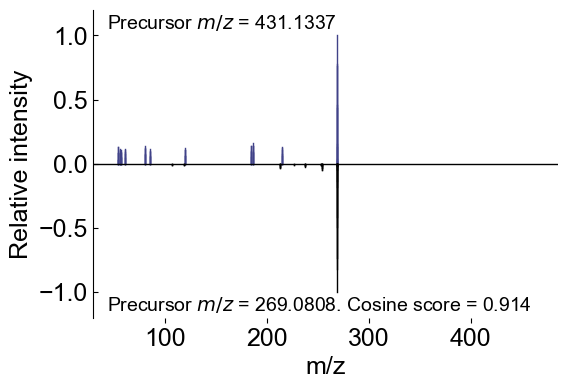

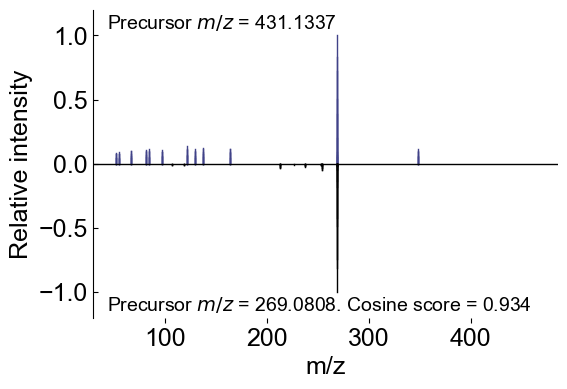

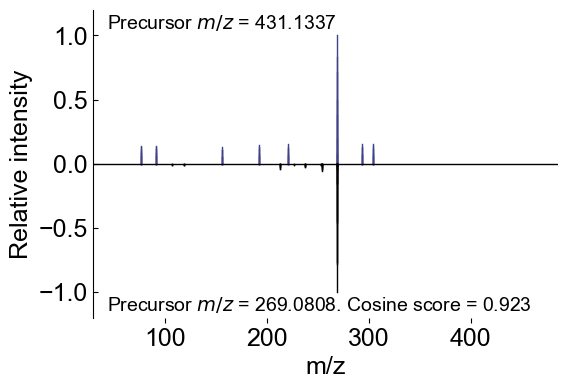

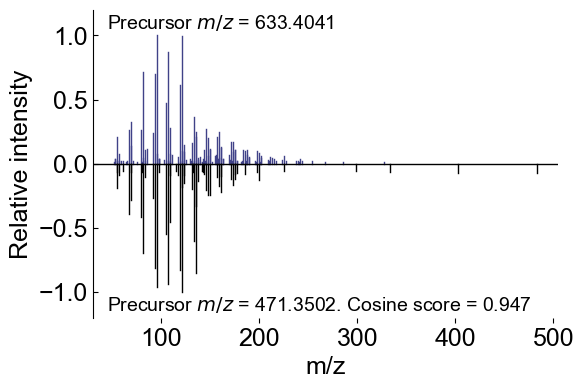

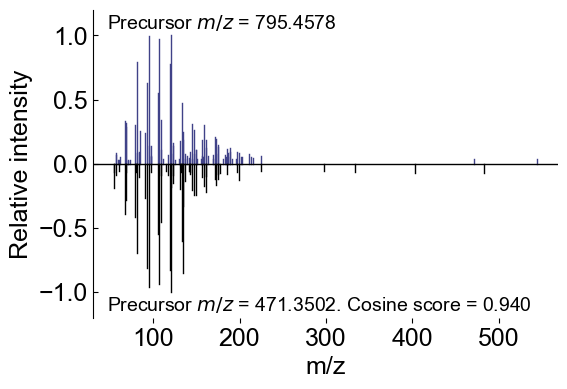

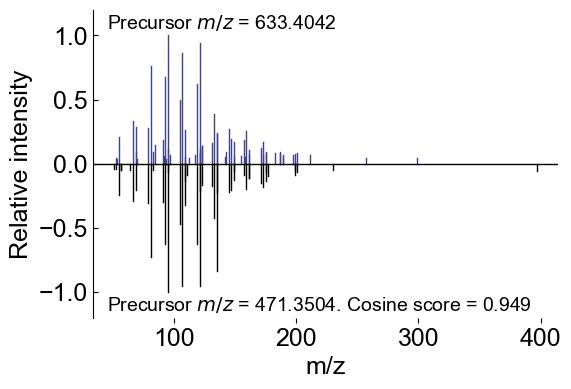

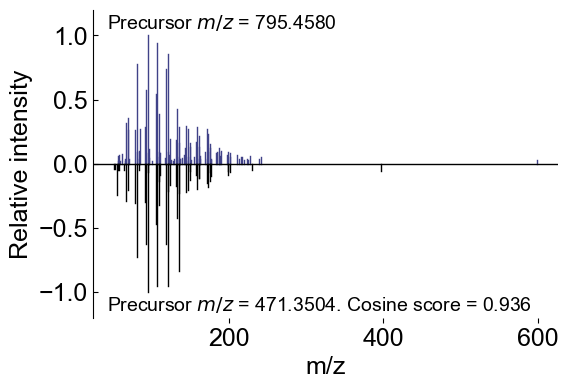

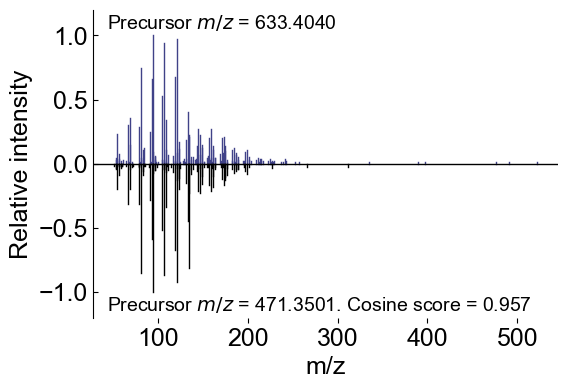

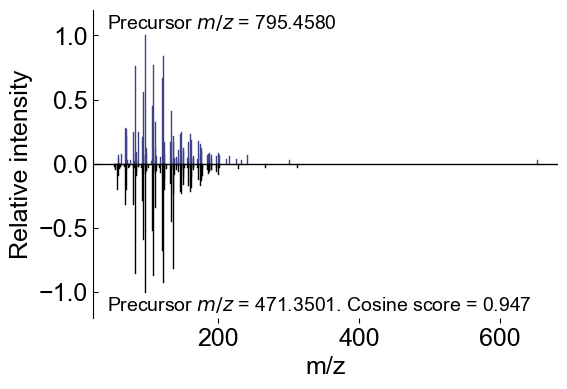

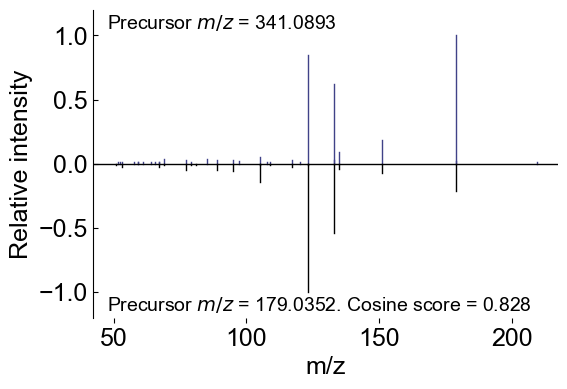

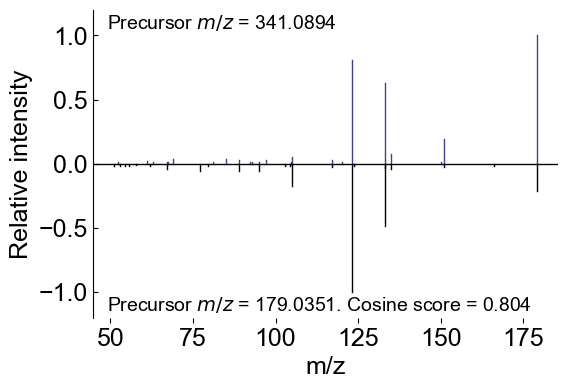

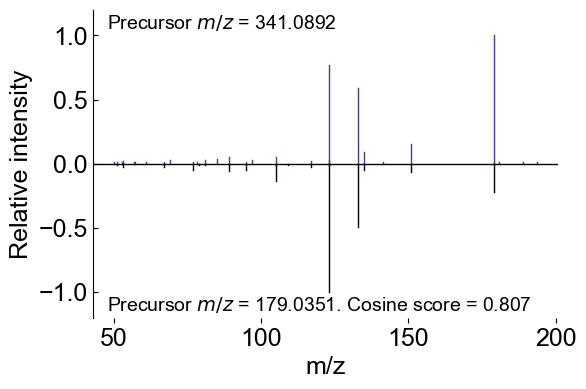

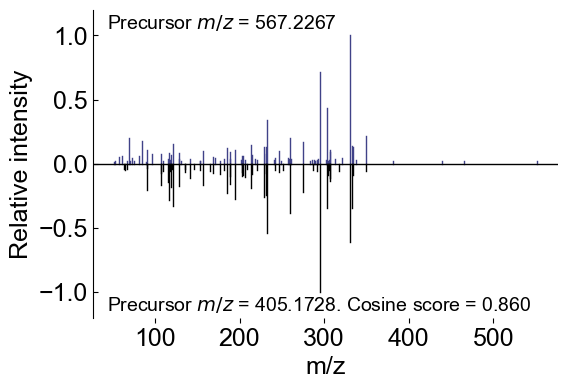

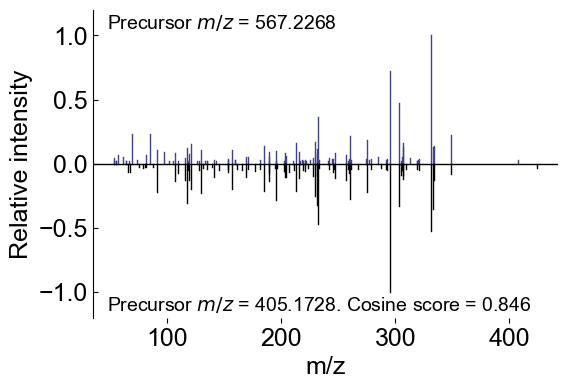

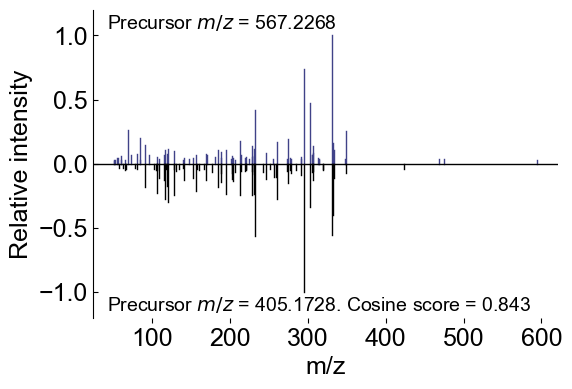

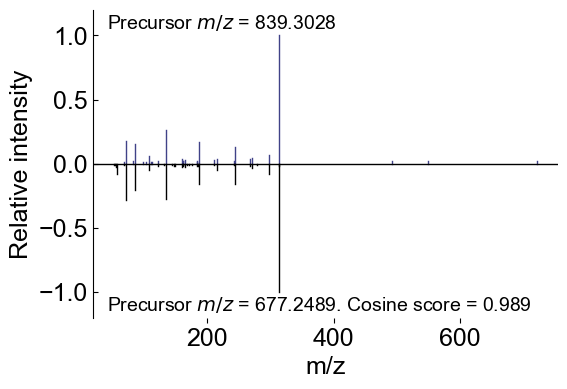

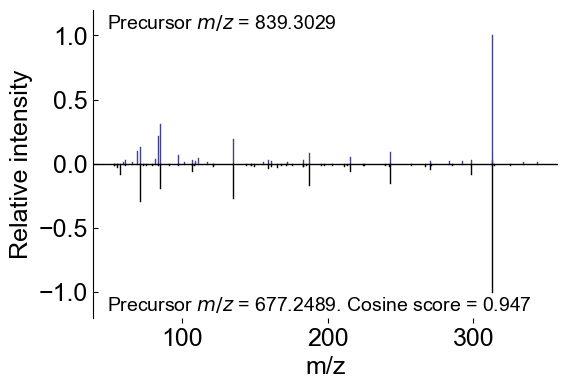

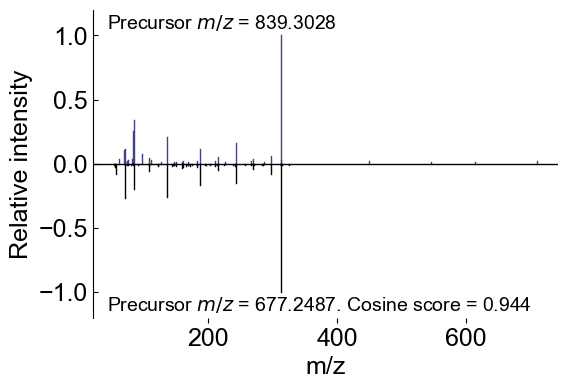

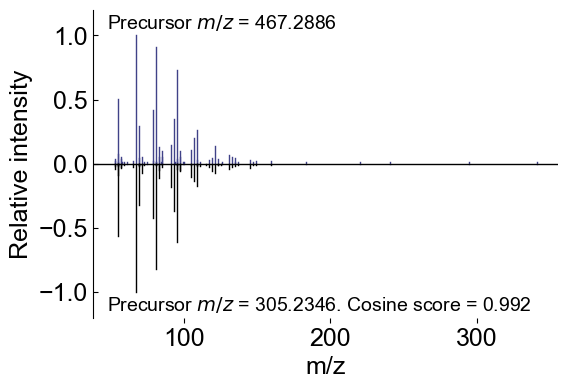

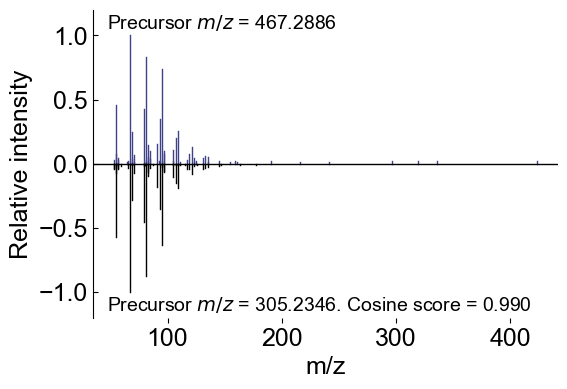

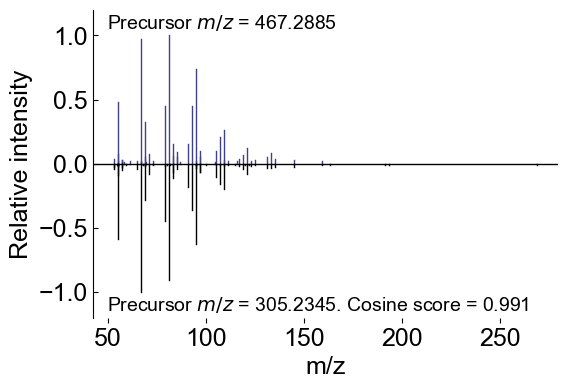

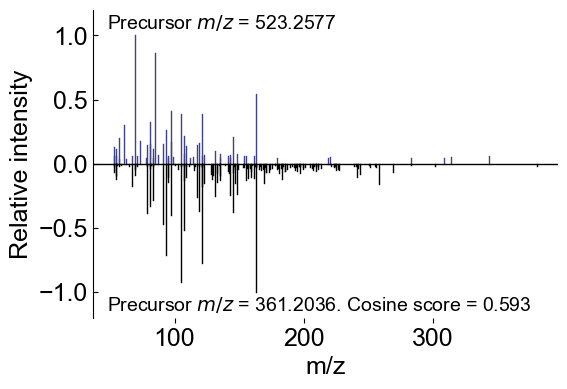

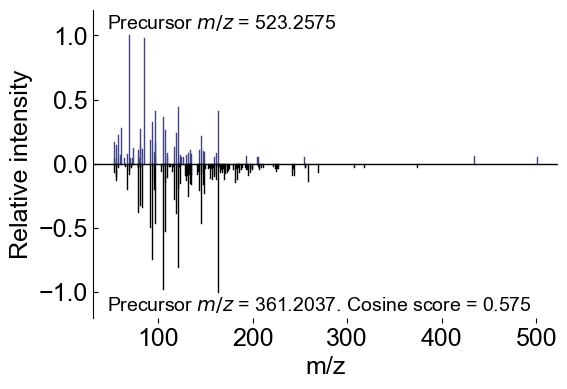

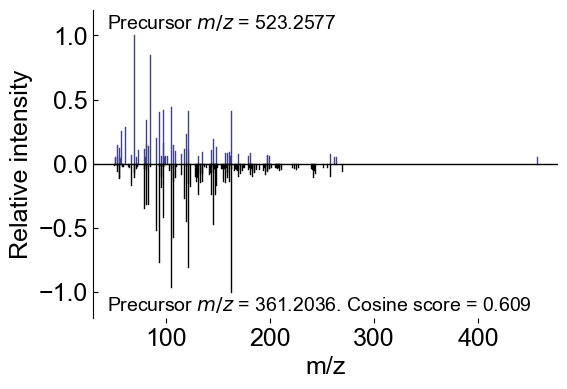

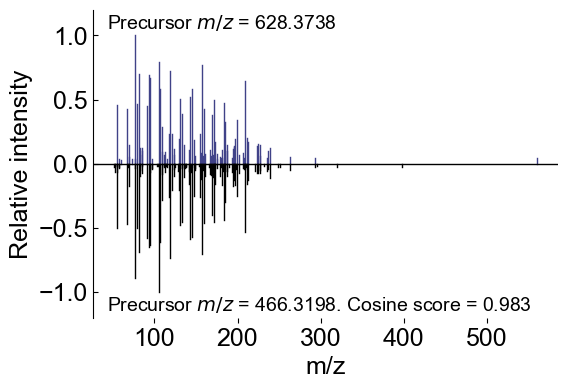

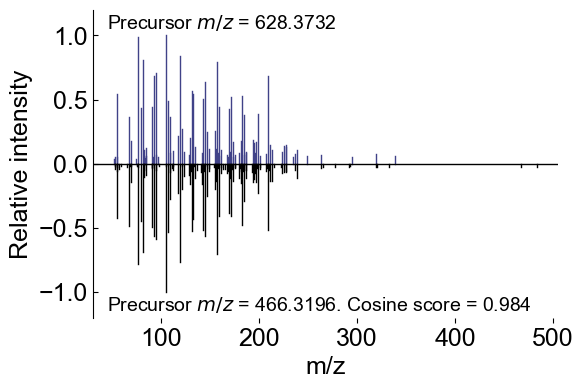

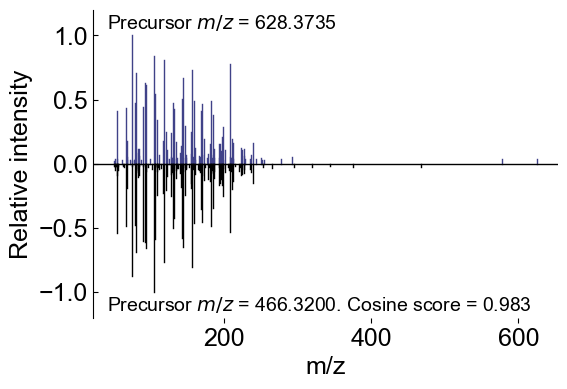

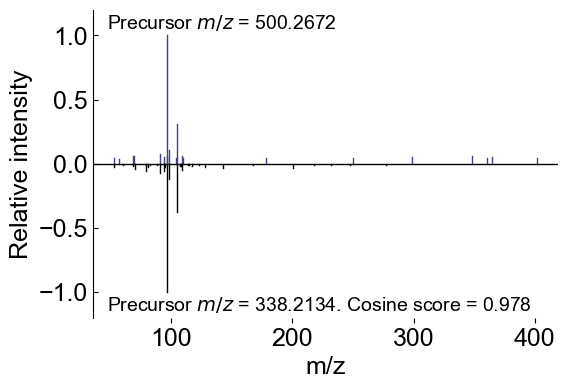

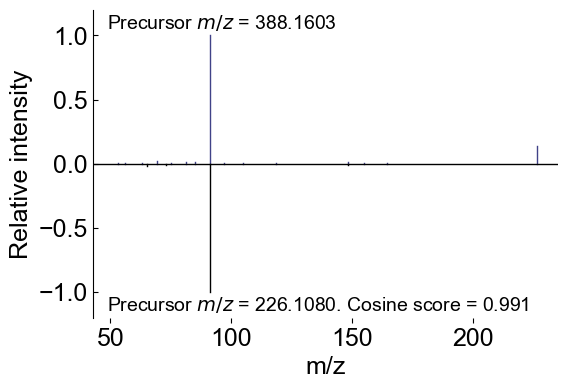

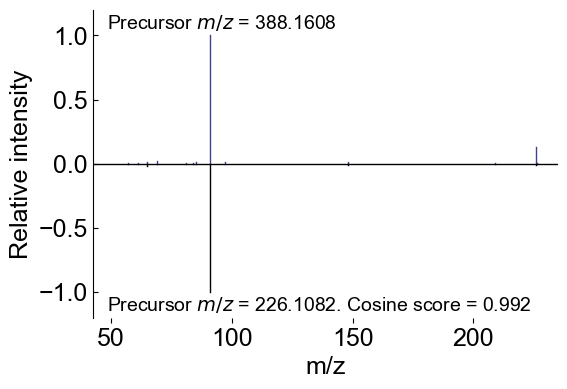

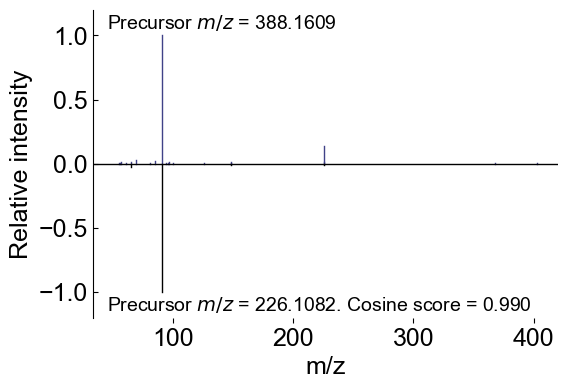

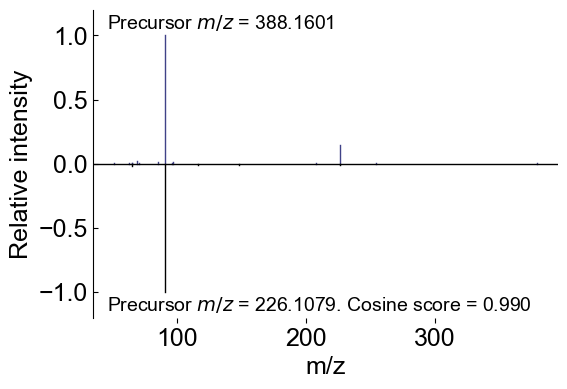

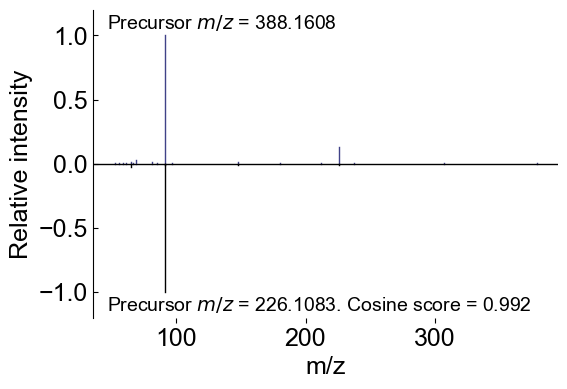

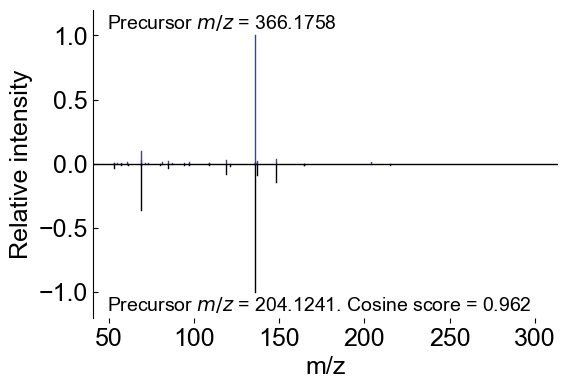

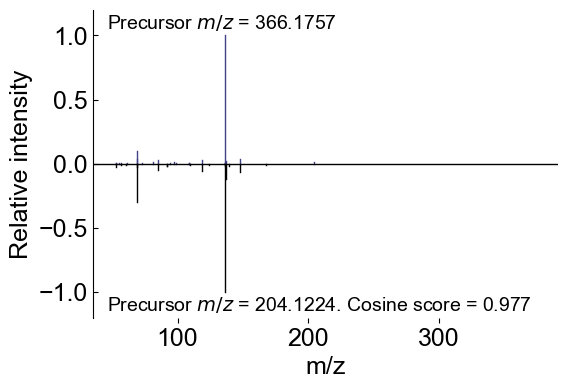

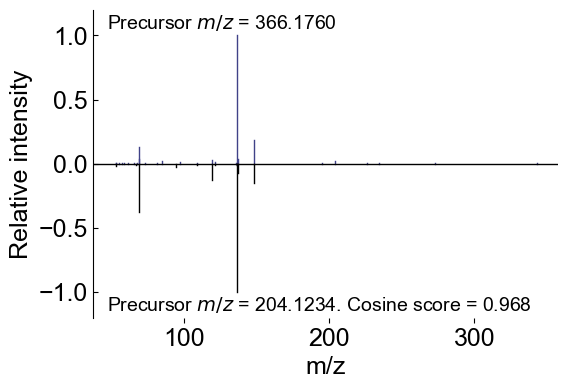

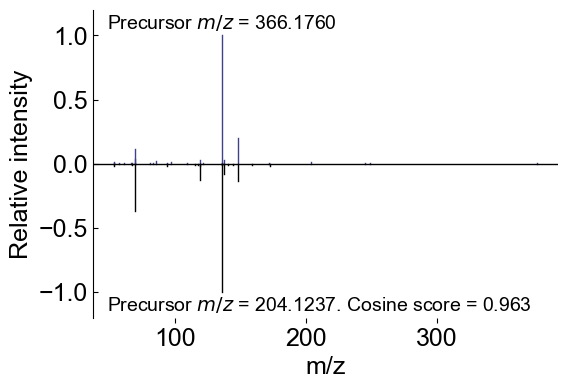

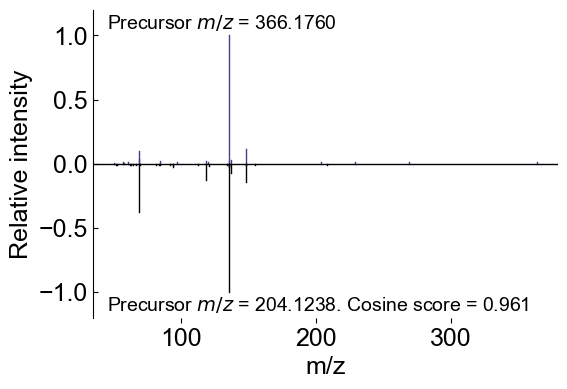

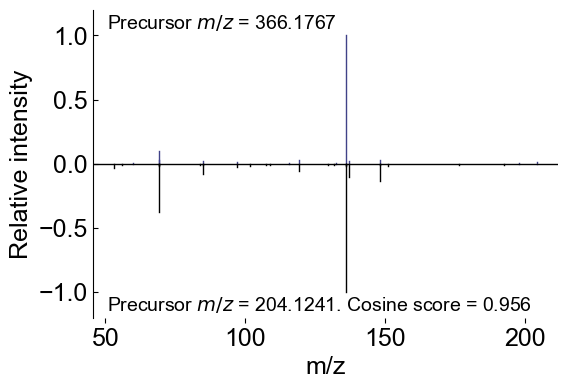

In [14]:
for _, row in df_res.iterrows():
    name_without_extension = row['filename']
    mz_substrate = row['mz_substrate']
    i_substrate = row['i_substrate']
    mz_substrate_precursor = row['mz_substrate_precursor']
    mz_monoproduct = row['mz_monoproduct']
    i_monoproduct = row['i_monoproduct']
    mz_monoproduct_precursor = row['mz_monoproduct_precursor']
    mz_diproduct = row['mz_diproduct']
    i_diproduct = row['i_diproduct']
    mz_diproduct_precursor = row['mz_diproduct_precursor']

    if len(i_substrate) > 0:
        if len(i_monoproduct) > 0:
            plot_mirror(mz_monoproduct, i_monoproduct, mz_substrate, i_substrate, mz_monoproduct_precursor, mz_substrate_precursor, 
                        #title = name + ' glucoside', 
                        filename=f'{name_without_extension}_glucoside')
        if len(i_diproduct) > 0:
            plot_mirror(mz_diproduct, i_diproduct, mz_substrate, i_substrate, mz_diproduct_precursor, mz_substrate_precursor, 
                        #title = name + ' diglucoside', 
                        filename=f'{name_without_extension}_diglucoside')